# **Кейс №2. Ковчег. Алексеев Виталий**

## **0 Импорт библиотек**

In [18]:
from dataclasses import dataclass
from itertools import product
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

plt.style.use('ggplot')
plt.rcParams["axes.facecolor"] = "white"

## **1 Загрузка данных**

In [19]:
df = pd.read_csv("https://raw.githubusercontent.com/zalig/cu-datasets/main/ark.csv")
df = df.set_index("Id")
df["Gender"] = pd.Categorical(df["Gender"])
df["Purchased"] = df["Purchased"].map({"No": 0, "Yes": 1})
df["Age"] = pd.Categorical(df["Age"])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, id1 to id80000
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Age        80000 non-null  category
 1   Gender     80000 non-null  category
 2   Purchased  80000 non-null  int64   
dtypes: category(2), int64(1)
memory usage: 1.4+ MB


,Age,Gender,Purchased
Id,,,
id1,<25,Male,0
id2,<25,Female,0
id3,<25,Female,1
id4,<25,Male,0
id5,25+,Male,0


## **2 Использование простого случайного семплирования**

**Простое случайное семплирование (simple random sampling)** $X_1,X_2,\dots, X_n$ размером $n$ наблюдений - это семплирование, при котором все выборки из $n$ наблюдений с учётом порядка без повторения элементов _равновероятны_.

Способ получения выборки по SRS:
1. По исходной генеральной совокупности строим генеральную совокупность всех возможных выборок
без возвращения, то есть без повторения из $n$ наблюдений с учётом порядка.
2. Выбираем одну выборку равновероятно, то есть выбираем элемент только что построенной генеральной совокупности выборок.

In [20]:
N = 10_000
size = 400

probabilities_srs = []
for _ in tqdm(range(N)):
    sample = df["Purchased"].sample(size)
    probabilities_srs.append(sample.mean())

p = df["Purchased"].mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

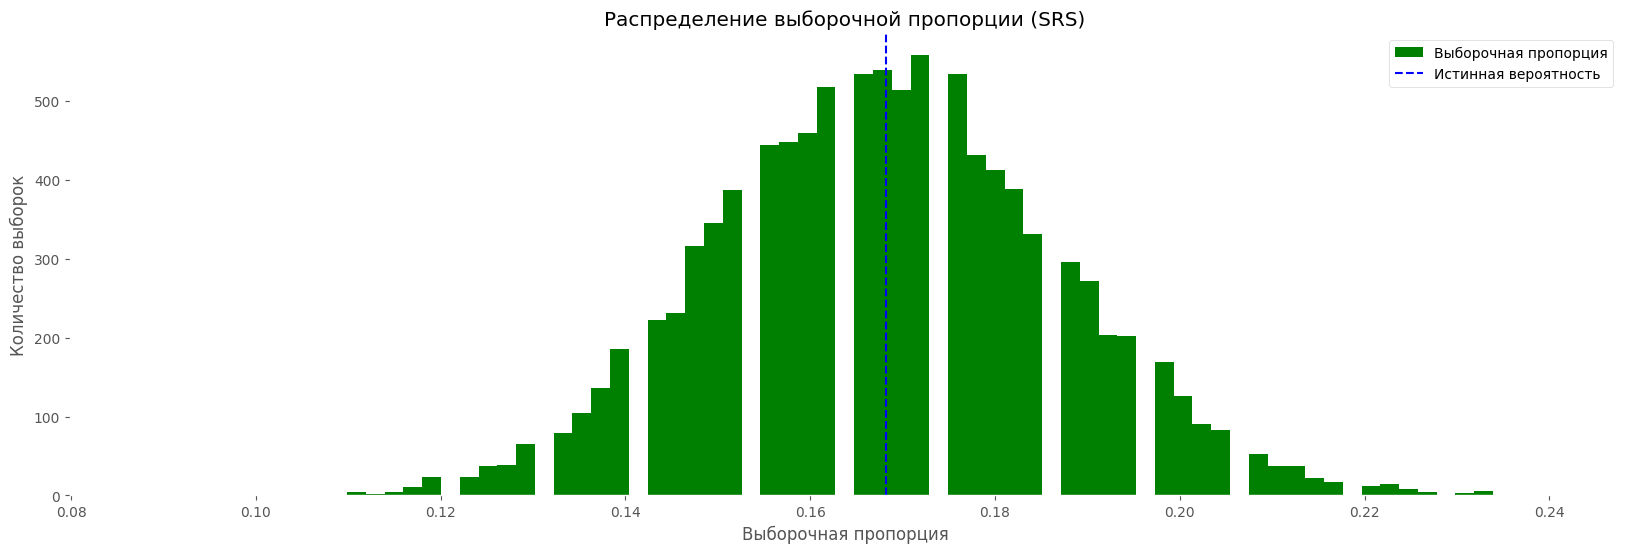

In [33]:
plt.figure(figsize=(20, 6))
plt.hist(probabilities_srs, bins=75, color="g", label="Выборочная пропорция")
plt.axvline(p, c="b", linestyle="dashed", label="Истинная вероятность")

plt.title("Распределение выборочной пропорции (SRS)")
plt.xlabel("Выборочная пропорция")
plt.ylabel("Количество выборок")
plt.legend()
plt.show()

Можно заметить, что систематической ошибки такой метод не дает, поскольку выборочная пропорция распределена симметрично относительно пропорции в генеральной совокупности.

Можно также заметить, что выборочная пропорция распределена нормально, по ЦПТ:
$$\hat{p}\xrightarrow{\text{d}}\mathcal{N}\left(p,\frac{p(1-p)}{n}\right)$$
Следовательно, по правилу трех сигм, погрешность с вероятностью $\approx 99,74\%$ по модулю не превосходит:
$$ME = 3\cdot\sqrt{\frac{p(1-p)}{n}}$$

In [22]:
print(f"ME = {3 * np.sqrt(p * (1 - p) / size)}")

ME = 0.05610324242802282


## **3 Использование случайного семплирования со стратификацией**

**Случайное семплирование со стратификацией (stratified random sampling)** размером $n$ наблюдений - это семплирование, при котором _равновероятны_ все выборки из $n$ наблюдений с учётом порядка без повторения элементов, для которых доля каждой страты в выборке _совпадает_ с долей этой страты в генеральной совокупности.

Способ получения стратифицированной выборки.
1. Для каждой страты вычисляем требуемое количество наблюдений из этой страты в выборке:
$$n_i = n \cdot \mathbf{P}(Stratum_i)$$
2. Из каждой страты получаем подвыборку нужного размера простым случайным семплированием.
3. Объединяем подвыборки в выборку.

В нашем датасете мы можем выделить 2 бинарных фактора стратификации, т.е. всего получается 4 страты:
- Женщины моложе 25
- Женщины старше 25
- Мужчины моложе 25
- Мужчины старше 25

In [23]:
@dataclass
class Strata:
    age: Literal["<25", "25+"]
    gender: Literal["Male", "Female"]

strats = []
for strata in product(("<25", "25+"), ("Male", "Female")):
    strats.append(Strata(*strata))

In [24]:
probabilities_strats = []
for _ in tqdm(range(N)):
    subsamples = []
    for strata in strats:
        filtered_df = df.loc[(df["Age"] == strata.age ) & (df["Gender"] == strata.gender), "Purchased"]
        n_i = len(filtered_df) / 80_000
        subsample = filtered_df.sample(frac=n_i)
        subsamples.append(subsample)
    sample = np.concatenate(subsamples)
    probabilities_strats.append(sample.mean())

  0%|          | 0/10000 [00:00<?, ?it/s]

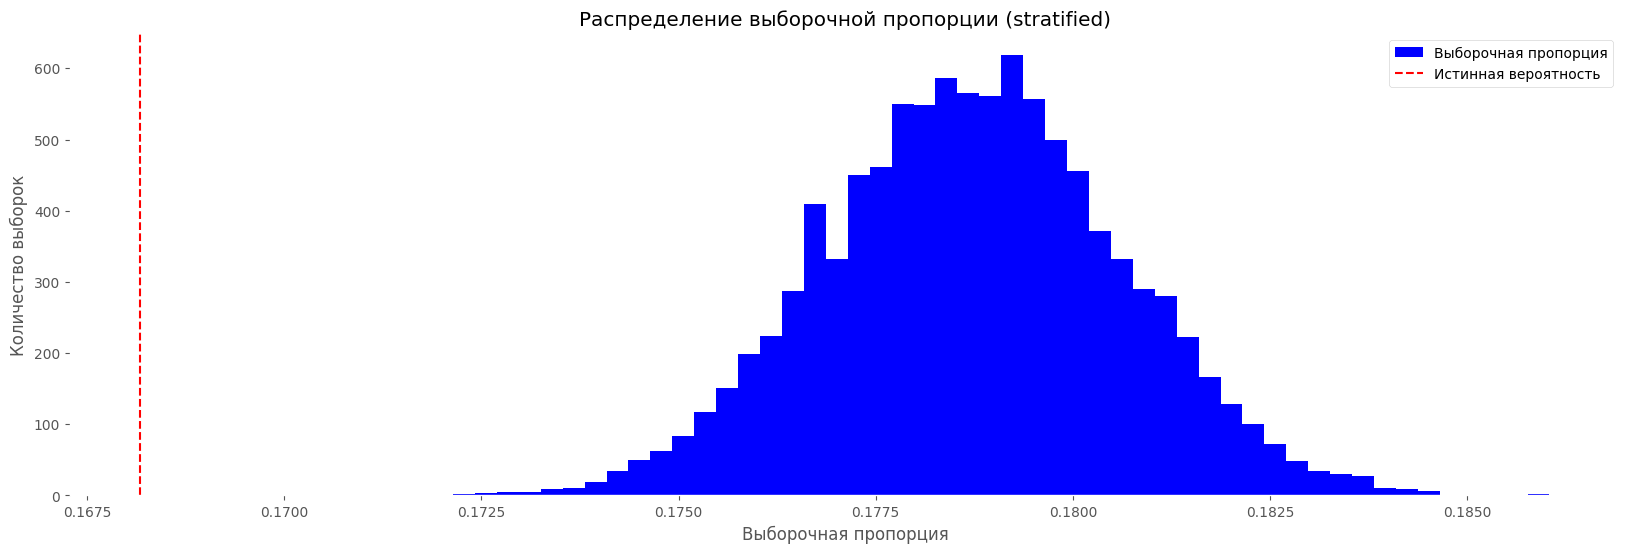

In [39]:
plt.figure(figsize=(20, 6))
plt.hist(probabilities_strats, bins=50, color="b", label="Выборочная пропорция")
plt.axvline(p, c="r", linestyle="dashed", label="Истинная вероятность")

plt.title("Распределение выборочной пропорции (stratified)")
plt.xlabel("Выборочная пропорция")
plt.ylabel("Количество выборок")
plt.legend()
plt.show()

Данный метод систематически завышает выборочную пропорцию: видно, что все значения гистограммы находятся правее от искомой вероятности.

Метод случайного семплирования со стратификацией может давать достаточно большие погрешности, их величина и частота появления во многом зависят от распределения целевой переменной по стратам в генеральной совокупности, иными словами:

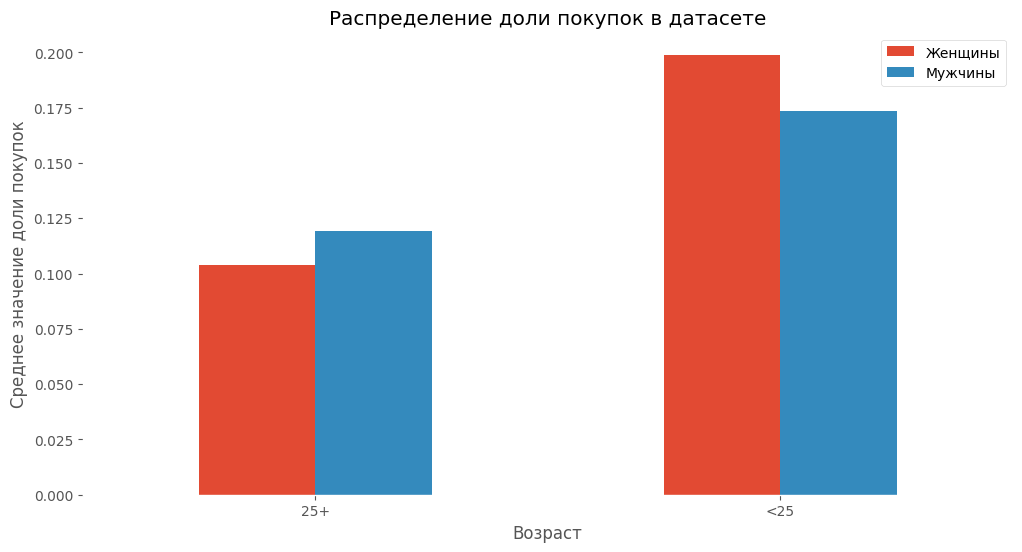

In [26]:
agg = df.groupby(
    ["Age", "Gender"],
    observed=True
)["Purchased"].mean().reset_index(name="conversion")

pivot = agg.pivot_table(
    index="Age",
    columns="Gender",
    values="conversion",
    observed=True
)
ax = pivot.plot(kind="bar", figsize=(12, 6), rot=0, grid=False)

ax.legend(["Женщины", "Мужчины"])
plt.title("Распределение доли покупок в датасете")
plt.ylabel("Среднее значение доли покупок")
plt.xlabel("Возраст")
plt.show()

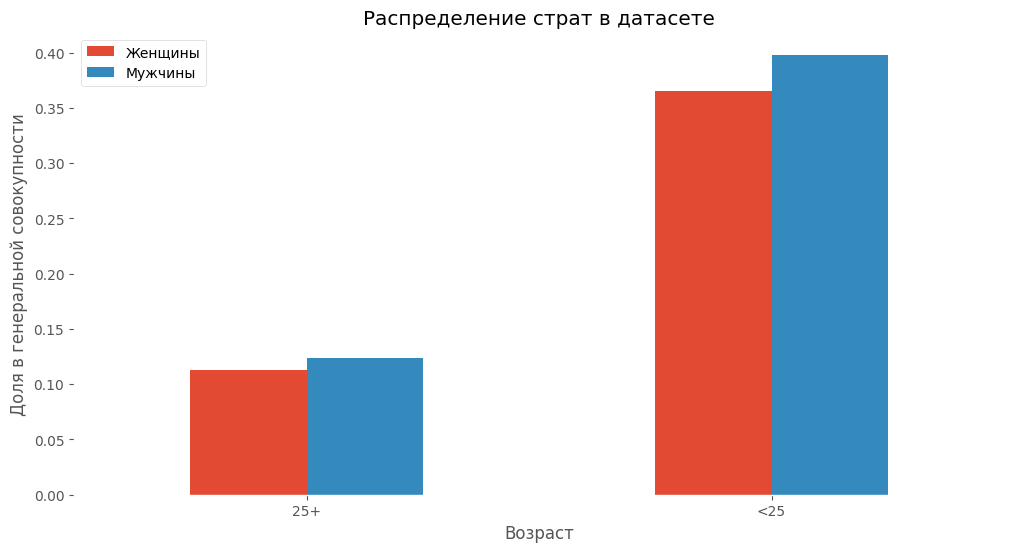

In [27]:
counts = df.groupby(["Age", "Gender"], observed=True).size().reset_index(name="n")

total_n = len(df)
counts["share"] = counts["n"] / total_n

pivot_share = counts.pivot_table(
    index="Age",
    columns="Gender",
    values="share",
    observed=True
)

ax = pivot_share.plot(
    kind="bar",
    figsize=(12, 6),
    rot=0,
    grid=False,
)

ax.legend(["Женщины", "Мужчины"])
plt.title("Распределение страт в датасете")
plt.ylabel("Доля в генеральной совокупности")
plt.xlabel("Возраст")
plt.show()

Теперь должно стать очевидно, откуда берется систематическое завышение: страты с возрастом старше 25 лет представлены большим числом записей, при этом они же и имеют большую долю покупок, таким образом выборка формирует _бОльшую_ долю записей с _бОльшим_ числом покупок.

Однако стоит отметить малый порядок отклонений, в то время как для SRS значение ошибки $ME$ составляло порядка $5\%$, для стратифицированного семплирования это $\approx 1,5\%$

## **4 Сравнение двух методов**

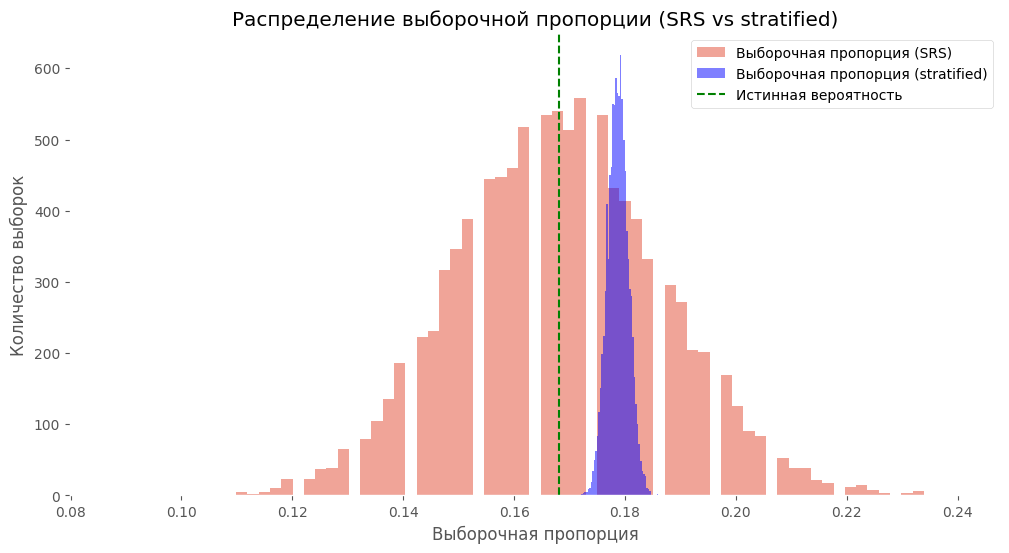

In [43]:
plt.figure(figsize=(12, 6))

plt.hist(probabilities_srs, bins=75, label="Выборочная пропорция (SRS)", alpha=0.5)
plt.hist(probabilities_strats, bins=50, label="Выборочная пропорция (stratified)", color="b", alpha=0.5)
plt.axvline(p, c="g", linestyle="dashed", label="Истинная вероятность")

plt.title("Распределение выборочной пропорции (SRS vs stratified)")
plt.xlabel("Выборочная пропорция")
plt.ylabel("Количество выборок")
plt.legend()
plt.show()

Метод простого случайного семплирования имеет более широкий разброс значений от $10\%$ до $24\%$, в то время как у стратифицированного это от $17\%$ до $18,5\%$, однако при этом SRS не имеет систематической ошибки, поскольку выборочное среднее для этого метода распределено симметрично относительно истинного значения. В то же время стратифицированное семплирование систематически завышает выборочное среднее.

Тем не менее, стратифицированное семплирование имеет гораздо меньшую, по сравнению с простым случайным, погрешность. Это достигается засчет сохранения доли каждой из страт, что максмиально приближает выборку к генеральной совокупности.

Можно заметить, что каждый из методов имеет как наиболее близкий к искомому результат, так и наиболее далекий от него. Видно это только, исходя из распределения большого числа выборок, лишь по результату одной из них невозможно было сделать никаких выводов о самом методе.